<a href="https://colab.research.google.com/github/satishchaudhary382/algorithmic-trading-with-python/blob/master/Analysis%2027.05.2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Scraping**

In [ ]:
!pip install selenium
!apt-get update 
!apt install chromium-chromedriver

!pip install MarketProfile
!pip install fake-useragent
!pip install mpl_finance
!pip install finta
!pip install -U git+https://github.com/twopirllc/pandas-ta
!pip install numpy --upgrade
!pip install mplfinance
# !pip install plotly
# !pip install altair
# !pip install pandas_datareader

In [1]:
#@title Importing Libraries
import time
import datetime
import pandas as pd
import numpy as np 
import warnings
warnings.filterwarnings("ignore")
from fake_useragent import UserAgent
import requests
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from finta import TA
from sklearn.preprocessing import MinMaxScaler
from selenium import webdriver
from market_profile import MarketProfile
import random
import pandas_ta as ta
useragent = UserAgent()
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from bokeh.plotting import figure, output_file, show
import bokeh
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import mplfinance as mpl
import altair as alt
from math import pi
from bokeh.io import output_notebook
from bokeh.models import Label
from datetime import datetime as dt
# Call once to configure Bokeh to display plots inline in the notebook.
output_notebook()
%matplotlib inline
from math import pi
from bokeh.models import Span
import matplotlib.dates as mpl_dates
import pandas_datareader as pdr

from bs4 import BeautifulSoup

from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.common.exceptions import TimeoutException
from selenium.webdriver.support.ui import Select

import urllib.request

In [29]:
stock = "CHL"

In [30]:
#@title Scarping
data = []
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
chrome_options.add_argument(f"user-agent = {useragent.random}")
wd = webdriver.Chrome('chromedriver',chrome_options=chrome_options)
driver =webdriver.Chrome('chromedriver',chrome_options=chrome_options)

delay = 10

url = f"https://merolagani.com/CompanyDetail.aspx?symbol={stock}"
wait = WebDriverWait(driver, 10)
driver.get(url)

price = wait.until(EC.element_to_be_clickable((By.XPATH,"//a[@title='Price History']")))
price.click()
time.sleep(10)

a=1
# while a<3:
tables = driver.find_element_by_xpath("//table[@class='table table-bordered table-striped table-hover']")
driver.execute_script("window.open(arguments[0], '_blank');", tables)
soup = BeautifulSoup(driver.page_source,'lxml')
table = soup.find('table', attrs={'class':'table table-bordered table-striped table-hover'})
table_rows = table.find_all('tr')
for tr in table_rows:
  td = tr.find_all('td')
  row = [tr.text for tr in td]
  data.append(row)
# driver.find_element_by_xpath('//*[@title="Next Page"]').click()
# wait.until(EC.element_to_be_clickable((By.CSS_SELECTOR,'a.Next Page'))).click()
# driver.find_element_by_xpath("//a[@title='Page 2']").click()
# driver.find_element_by_xpath("//div[@id='ctl00_ContentPlaceHolder1_CompanyDetail1_divDataPrice']/div[1]/div[2]/a[6]").click()
time.sleep(5)
a+=1
driver.quit()
print(f"Done Scrapping {stock}")

Done Scrapping CHL


In [32]:
#@title Preparing Data OHLCV
Date = []
Close = []
High = []
Open = []
Low = []
Volume = []
for i in range(len(data)):
  try:
    Date.append(data[i][1])
    Close.append(data[i][2])
    High.append(data[i][4])
    Low.append(data[i][5])
    Open.append(data[i][6])
    Volume.append(data[i][7])
  except:
    pass
df = pd.DataFrame({"Date":Date,
                   "Close":Close,
                   "Open":Open,
                   "High":High,
                   "Low":Low,
                   "Close":Close,
                   "Volume":Volume}) 
df['Date'] = pd.to_datetime(df['Date'])
df['Open'] = pd.to_numeric([float(f"{i}".replace(",","")) for i in df['Open']])
df['High'] = pd.to_numeric([float(f"{i}".replace(",","")) for i in df['High']])
df['Low'] = pd.to_numeric([float(f"{i}".replace(",","")) for i in df['Low']])
df['Close'] = pd.to_numeric([float(f"{i}".replace(",","")) for i in df['Close']])
df['Volume'] = pd.to_numeric([float(f"{i}".replace(",","")) for i in df['Volume']])
# df.sort_values(by = "Date", ascending = True, axis = 1)
df = df.set_index("Date")
df.to_csv(f"{stock}.csv")


In [33]:
#@title TRIMA band
def trima(df):
  df['trima'] = ta.trima(df['Close'],21)
  df['range'] = ta.atr(df.High, df.Low, df.Close, 14) * 4
  df['H'] = ta.wma((df['trima'] + df['range']),21)
  df['L'] = ta.wma((df['trima'] - df['range']),21)
  df['SD_UP'] = df['H'].rolling(20).std()
  # df['SD_DOWN'] = ((df['trima'] - df['range'])).rolling(20).std()
  df['HH'] = ta.wma((df['trima'] + df['range']),21)+(ta.atr(df.High, df.Low, df.Close,21))*1
  df['LL'] = ta.wma((df['trima'] - df['range']),21)-(ta.atr(df.High, df.Low, df.Close,21))*1
  return df[['HH','H','LL','L']]

In [34]:
#@title Market Profile
from market_profile import MarketProfile

# df = pdr.get_data_yahoo(f'{stock}',"12-1-2020")
df = pd.read_csv(f"/content/{stock}.csv")


class Analysis:
    def __init__(self, dataframe):
        self.dataframe = dataframe
        self.profile = []
        self.levels = []
        self.level = []

  # Calculation of Market Profile
    def market_profile(self):
        for i in range(1,len(self.dataframe),21):
            try:
                mp = MarketProfile(self.dataframe)
                mp_slice = mp[self.dataframe.index[0+i]: self.dataframe.index[21+i]]
                self.profile.append(mp_slice.poc_price)
            except:
                pass
        return self.profile


a = Analysis(df)
b = a.market_profile()

In [35]:
#@title Smoothed HA
def SHA(df, length):
  import warnings
  warnings.filterwarnings("ignore")

  import matplotlib.pyplot as plt
  from bokeh.plotting import figure, output_file, show
  import bokeh
  from math import pi
  from bokeh.io import output_notebook
  from bokeh.models import Label
  from datetime import datetime as dt
  # Call once to configure Bokeh to display plots inline in the notebook.
  output_notebook()
  %matplotlib inline
  from math import pi
  from bokeh.models import Span
  w_l = length
  df['O'],df['H'],df['L'],df['C']= ta.ema(df['Open'], w_l),ta.ema(df['High'], w_l),ta.ema(df['Low'], w_l),ta.ema(df['Close'], w_l)
  df = df.dropna()
  df['C_1'] = (df['O']+df['H']+df['L']+df['O'])/4
  O,C = [df['O'][0]],[df['C'][0]]
  o,c = df['O'].shift(-1),df['C'].shift(-1)
  t= (o+c)/2
  r = t.shift(1)
  r[np.isnan(r)]=df['O'][0]
  df['O_1'] = t
  df['H_1'] = df[['H','O_1']].max(axis=1)
  df['L_1'] = df[['L','O_1']].min(axis=1)
  df['O_2'] = ta.ema(df['O_1'],w_l)
  df['L_2'] = ta.ema(df['L_1'],w_l)
  df['H_2'] = ta.ema(df['H_1'],w_l)
  df['C_2'] = ta.ema(df['C_1'],w_l)
  df['C_2'][-1] = df.C_2[-2]
  # df = df.dropna()
  # df = df[['O_2','H_2','L_2','C_2','Volume']]
  df = df.reset_index()
  return df[['Date','Open','High','Low','Close','O_2','H_2','L_2','C_2']]

In [36]:
#@title Fractals
def fractals(df,number):
  data = df.copy(deep = True)
  def wilFractal(df):
      periods = (-2, -1, 1, 2)

      bear_fractal = pd.Series(np.logical_and.reduce([
        df['High'] > df['High'].shift(period) for period in periods
      ]), index=df.index)

      bull_fractal = pd.Series(np.logical_and.reduce([
        df['Low'] < df['Low'].shift(period) for period in periods
      ]), index=df.index)

      return bear_fractal, bull_fractal
  data = df.reset_index()
  data['bull'] = wilFractal(data)[0]
  final = []
  final1 = []
  l = data[data['bull']==True][-3:].index.values
  value = data[data.index==l[number]]
  for i in range(int(value.index.values)):
      final.append(np.nan)
  for i in range(int(value.index.values), len(data)):
      final1.append(float(value['High'].values))
  return final+final1

In [37]:
#@title Indicator Calculation

# df = pdr.get_data_yahoo(f'{stock}',"12-1-2020")
df = pd.read_csv(f"/content/{stock}.csv")
df = df.set_index("Date")
df = df.sort_index(ascending = True)

# Heikin ashi 1
h1 = df.copy(deep = True)
ha1 = SHA(h1,5)
# Heikin ashi 2
h2 = df.copy(deep = True)
ha2 = SHA(h2,8)

# Squeeze
s = df.copy(deep = True)
s['low'] = ta.squeeze(df['High'],df['Low'], df['Close'],20,2,20,1)['SQZ_ON']
s['med'] = ta.squeeze(df['High'],df['Low'], df['Close'],20,1.6,20,1)['SQZ_ON']
s['high'] = ta.squeeze(df['High'],df['Low'], df['Close'],20,1,20,1)['SQZ_ON']

s['low_h'] = s.apply(lambda x: x['High']+3 if x['low']!=0 else np.nan, axis = 1)
s['low_l'] = s.apply(lambda x: x['Low']-3 if x['low']!=0 else np.nan, axis =1 )
s['med_h'] = s.apply(lambda x: x['High']+5 if x['med']!=0 else np.nan, axis = 1)
s['med_l'] = s.apply(lambda x: x['Low']-5 if x['med']!=0 else np.nan, axis =1 )
s['high_h'] = s.apply(lambda x: x['High']+8 if x['high']!=0 else np.nan, axis = 1)
s['high_l'] = s.apply(lambda x: x['Low']-8 if x['high']!=0 else np.nan, axis =1 )

# Even better sine wave
ebsw = df.copy(deep = True)
ebsw['ebsw'] = ta.ssf(ta.ebsw(df['Close']).fillna(method = 'bfill'))
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(ha1['C_2'].min(), ha1['C_2'].max()))
ebsw['final'] =  scaler.fit_transform(ebsw['ebsw'].values.reshape(-1, 1))

# TRIMA
tma = df.copy(deep = True)
dfs = trima(tma)

# WTO
o = df.copy(deep = True)
o['WT1'] = TA.WTO(df)['WT1.'].fillna(method = 'bfill')
o['WT2'] = TA.WTO(df)['WT2.'].fillna(method = 'bfill')

# Bear and Bull
bb = df.copy(deep = True)
bb['EFI'] = TA.EFI(bb,7)
bb['EFI1'] = TA.EFI(bb,9)
bb['EFI2'] = TA.EFI(bb,13)
bb['m'] = (bb['EFI']+bb['EFI1']+bb['EFI2'])/3
bb['colorm'] = np.where(bb['m']<0, 'red','green')
sign = bb["m"] >= 0

bb["cumsum"] = bb["m"].groupby((sign != sign.shift()).cumsum()).cumsum()

# Fractals
fract = df.copy(deep = True)
fract['a'] = fractals(fract,0)
fract['b'] = fractals(fract,1)
fract['c'] = fractals(fract,2)


In [38]:
#@title Plotting
fig = make_subplots(rows=4, cols=1, shared_xaxes=True, 
               vertical_spacing=0.02, 
               row_width=[0.4,0.4,0.4,0.7]) # subplot_titles=(f'{stock}') if want to add title

# Candle stick chart
fig.add_trace(go.Candlestick(x=df.index,open=df['Open'],high=df['High'],low=df['Low'],close=df['Close'], 
                             name = 'Candlestick',increasing_line_color= '#000000', decreasing_line_color= '#000000',
                             decreasing_fillcolor = "#FFFFFF", increasing_fillcolor = "#000000", 
                             increasing_line_width=1,decreasing_line_width=1), row=1, col=1)

# Heikin ashi chart 1
fig.add_trace(go.Candlestick(x=ha1['Date'],open=ha1['O_2'],high=ha1['C_2'],low=ha1['L_2'],close=ha1['C_2'], 
                             name = 'Trend Filter1', 
                             increasing_line_width=1,decreasing_line_width=1), row=2,col=1)

#Heikin ashi chart 2
fig.add_trace(go.Candlestick(x=ha2['Date'],open=ha2['O_2'],high=ha2['C_2'],low=ha2['L_2'],close=ha2['C_2'], 
                             name = 'Trend Filter2', 
                             increasing_line_width=1,decreasing_line_width=1), row=2,col=1)
fig.add_trace(go.Scatter(x = ebsw.index, y = ebsw['final'] ,mode = 'lines', line_color='black',line=dict(color='black',width=1), 
                         opacity = 0.4, name = 'Cycle'), row=2, col=1)

# Squeeze 
fig.add_trace(go.Scatter(x=s.index, y=s.low_h,mode='markers', marker_size = 3,marker_color = '#42f5e6'), row=1, col=1)
fig.add_trace(go.Scatter(x=s.index, y=s.low_l,mode='markers', marker_size = 3,marker_color = '#42f5e6'), row=1, col=1)
fig.add_trace(go.Scatter(x=s.index, y=s.med_h,mode='markers', marker_size = 4,marker_color = '#f542e3'), row=1, col=1)
fig.add_trace(go.Scatter(x=s.index, y=s.med_l,mode='markers', marker_size = 4,marker_color = '#f542e3'), row=1, col=1)
fig.add_trace(go.Scatter(x=s.index, y=s.high_h,mode='markers', marker_size = 5,marker_color = '#f70a0a'), row=1, col=1)
fig.add_trace(go.Scatter(x=s.index, y=s.high_l,mode='markers', marker_size = 5,marker_color = '#f70a0a'), row=1, col=1)

#Volume Profile 
# SR Volume Profile
for line in b:
    fig.add_trace(go.Scatter(x = df.index, y = pd.Series(np.array([line for _ in range(len(df))])), mode = 'lines', line = dict(color = "red", width = 1), name = "VP S/R"))

# Bull fractals

fig.add_trace(go.Scatter(x = fract.index, y = fract.a, mode = 'lines', line = dict(color = "blue",width = 1)),row=1, col = 1)
fig.add_trace(go.Scatter(x = fract.index, y = fract.b, mode = 'lines', line = dict(color = "blue",width = 1)),row=1, col = 1)
fig.add_trace(go.Scatter(x = fract.index, y = fract.c, mode = 'lines', line = dict(color = "blue",width = 1)),row=1, col = 1)




#TRIMA
# Upper and Lower Resistance
fig.add_trace(go.Scatter(x=dfs.index, y=dfs.HH,fill=None, mode='lines',line_color='green',line=dict(color='green',width=1),opacity=0.3, name = "Upper Resistance 1"),row=1,col=1)
fig.add_trace(go.Scatter(x=dfs.index, y=dfs.H,fill='tonexty',mode='lines', line_color='green',line=dict(color='green',width=1),opacity=0.3,name = "Upper Resistance 2"),row=1,col=1)   
fig.add_trace(go.Scatter(x=dfs.index, y=dfs.LL,fill=None, mode='lines',line_color='red',line=dict(color='red',width=1), name = "Lower Support 1"),row=1,col=1)
fig.add_trace(go.Scatter(x=dfs.index, y=dfs.L,fill='tonexty',mode='lines', line_color='red',line=dict(color='red',width=1), name = "Lower Support 2"),row=1,col=1)

#OverBought and OverSold
#Over Bought and Over Sold along with Mass Index
fig.add_trace(go.Scatter(x = o.index, y = ta.ssf(o['WT1']),fill =None, mode = 'lines',line_color='green',line=dict(color='green',width=1),name='WT1'), row = 3, col = 1)
fig.add_trace(go.Scatter(x = o.index, y = ta.ssf(o['WT2']), mode = 'lines',line_color='red',line=dict(color='red',width=1),name='WT2'), row = 3, col = 1)
fig.add_trace(go.Scatter(x = o.index, y = pd.Series(np.array([0 for _ in range(len(o))])), mode = 'lines', line = dict(color = 'black', width =1, dash = 'dot'), name = 'Zero Line'), row = 3,col = 1)
fig.add_trace(go.Scatter(x = o.index, y = pd.Series(np.array([53 for _ in range(len(o))])), mode = 'lines', line = dict(color = 'black', width =1, dash = 'dot'), name = 'Zero Line'), row = 3,col = 1)
fig.add_trace(go.Scatter(x = o.index, y = pd.Series(np.array([60 for _ in range(len(o))])), mode = 'lines', line = dict(color = 'black', width =1, dash = 'dot'), name = 'Zero Line'), row = 3,col = 1)
fig.add_trace(go.Scatter(x = o.index, y = pd.Series(np.array([-53 for _ in range(len(o))])), mode = 'lines', line = dict(color = 'black', width =1, dash = 'dot'), name = 'Zero Line'), row = 3,col = 1)
fig.add_trace(go.Scatter(x = o.index, y = pd.Series(np.array([-60 for _ in range(len(o))])), mode = 'lines', line = dict(color = 'black', width =1, dash = 'dot'), name = 'Zero Line'), row = 3,col = 1)

#Bear and Bull volume
# fig.add_trace(go.Bar(name='Bull and Bear',x=bb.index,y=bb.m,marker_color=bb['colorm']), row= 4, col = 1)
fig.add_trace(go.Bar(name='Bull and Bear',x=bb.index,y=bb['cumsum'],marker_color=bb['colorm']), row= 4, col = 1)


fig.update_layout(title = stock, xaxis_rangeslider_visible=False,showlegend = False,barmode='stack',height=1000) #xaxis_title="Date"
fig.update_xaxes(rangeslider= {'visible':False}, row=1, col=1)

fig.update_xaxes(rangeslider= {'visible':False}, row=2, col=1)
fig.update_xaxes(showgrid=True,gridwidth=1, gridcolor='gray')
fig.update_yaxes(title_text = "Price",row=1, col=1)
fig.update_yaxes(title_text = "Price",row=2, col=1)
fig.update_yaxes(title_text = "Value",row=3, col=1)
fig.update_yaxes(title_text = "Volume",row=4, col=1)
# fig.update_yaxes(showgrid=False, gridwidth=1, gridcolor='gray')
fig.update_layout({'plot_bgcolor': 'rgba(0, 0, 0, 0)','paper_bgcolor': 'rgba(0, 0, 0, 0)'})

fig.show()

In [16]:
# stock = "SDLBSL"
# df = pd.read_csv(f"/content/{stock}.csv")
import pandas_ta as ta
import pandas_datareader as pdr
import altair as alt
import pandas as pd
df = pdr.get_data_yahoo("DIS","1-1-2020")


df = df.reset_index()
# df = df.set_index("Date")
df = df.sort_values(by ='Date',ascending = True)
length = 13
df['rsi'] = ta.rsi(df['Close'],length)
df['ma'] = ta.sma(df['rsi'],34)
df['offs'] = 1.6185*df['rsi'].rolling(34).std()

df['up'] = df['ma'] + df['offs']
df['dn'] = df['ma'] - df['offs']
df['mid'] = (df['up']+df['dn'])/2
df['mab'] = ta.sma(df['rsi'],2)
df['mbb'] = ta.sma(df['rsi'],7)
# df[['up','dn','mid','mab','mbb']].plot(figsize = (20,10))
# plt.plot(df['up'])
# plt.hlines([40 for i in range(len(df))],df.index.min(), df.index.max(), colors = 'red')
# plt.hlines(60,df.index.min(), df.index.max(), colors = 'red')
df

,Date,High,Low,Open,Close,Volume,Adj Close,rsi,ma,offs,up,dn,mid,mab,mbb
0,2020-01-02,148.199997,145.100006,145.289993,148.199997,9502100,148.199997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-03,147.899994,146.050003,146.399994,146.500000,7320200,146.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-06,146.029999,144.309998,145.539993,145.649994,8262500,145.649994,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-07,146.869995,145.419998,145.990005,145.699997,6906500,145.699997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-08,146.130005,144.820007,145.490005,145.399994,6984200,145.399994,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348,2021-05-20,171.899994,168.979996,169.210007,171.360001,7400700,171.360001,30.677670,41.879895,12.726564,54.606459,29.153331,41.879895,27.194546,28.757796
349,2021-05-21,173.119995,171.520004,172.220001,172.399994,8097500,172.399994,33.929973,41.431161,12.735799,54.166961,28.695362,41.431161,32.303822,28.746262
350,2021-05-24,175.110001,171.750000,172.449997,174.309998,7346700,174.309998,39.570655,41.085182,12.424485,53.509667,28.660696,41.085182,36.750314,29.317229
351,2021-05-25,177.449997,175.399994,175.600006,176.169998,8089700,176.169998,44.563666,40.998874,12.330598,53.329473,28.668276,40.998874,42.067160,31.595017


In [17]:
line = alt.Chart(df).mark_line(interpolate='basis').encode(
    x='Date:T',
    y='mab:Q',color=alt.value("#11bf2e"))
line1 = alt.Chart(df).mark_line(interpolate='basis').encode(
    x='Date:T',
    y='mbb:Q',color=alt.value("#d91009"))
line2 = alt.Chart(df).mark_line(interpolate='basis').encode(
    x='Date:T',
    y='mid:Q',color=alt.value("#eded09"))
line3 = alt.Chart(df).mark_line(interpolate='basis').encode(
    x='Date:T',
    y='up:Q')
line4 = alt.Chart(df).mark_line(interpolate='basis').encode(
    x='Date:T',
    y='dn:Q')
line5 = alt.Chart(pd.DataFrame({'y': [50]})).mark_rule().encode(y='y')
line6 = alt.Chart(pd.DataFrame({'y': [60]})).mark_rule().encode(y='y')
line7 = alt.Chart(pd.DataFrame({'y': [40]})).mark_rule().encode(y='y').properties(
    width=800,
    height=500
)


In [18]:
line+line1+line2+line3+line4+line5+line6+line7

alt.LayerChart(...)

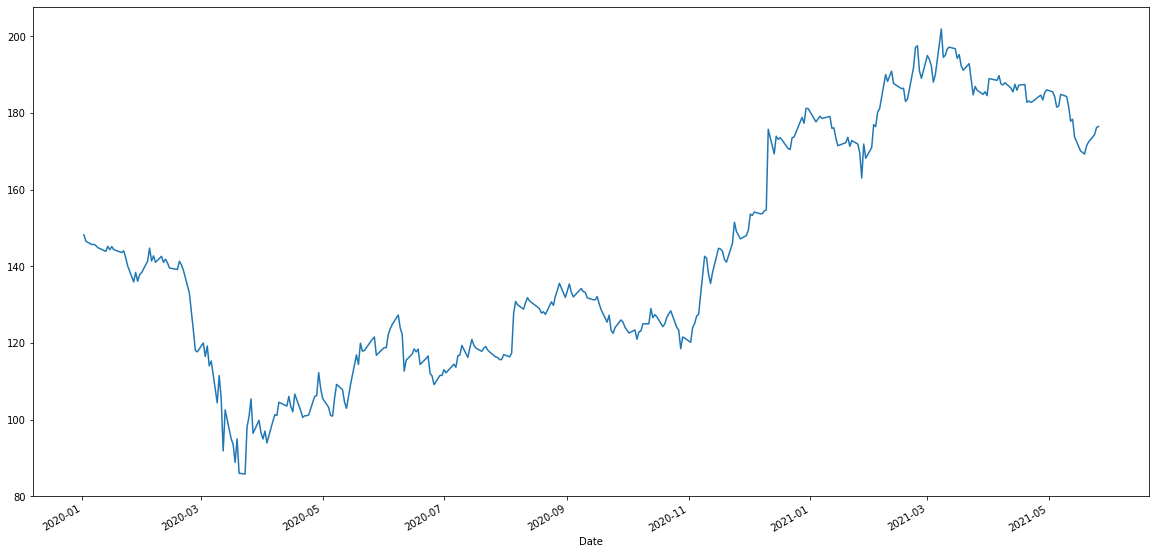

In [19]:
df.set_index("Date")['Close'].plot(figsize = (20,10))

In [21]:
df = pdr.get_data_yahoo("DIS","1-1-2020")

df[df['Close']==85.76000213623047]

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-03-23,87.279999,81.089996,84.489998,85.760002,32246600,85.760002


In [23]:
# df['Close'].tail()
176.169998/85.76000213623047

2.054221007599236

In [25]:
df[df['Close']==df['Close'].max()]

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-03-08,203.020004,193.789993,197.309998,201.910004,25093200,201.910004


In [28]:
176.169/500.91

0.35169790980415644

In [73]:
df['Date'] = pd.to_datetime(df['Date'])
df['Open'] = pd.to_numeric([float(f"{i}".replace(",","")) for i in df['Open']])
df['High'] = pd.to_numeric([float(f"{i}".replace(",","")) for i in df['High']])
df['Low'] = pd.to_numeric([float(f"{i}".replace(",","")) for i in df['Low']])
df['Close'] = pd.to_numeric([float(f"{i}".replace(",","")) for i in df['Close']])
df['Volume'] = pd.to_numeric([float(f"{i}".replace(",","")) for i in df['Volume']])
df.sort_values(by = "Date", ascending = True)
df = df.set_index("Date")
df.to_csv("ALICL.csv")